## Prepare TADPOLE data

### Training data

In [781]:
import numpy as np
import pandas as pd
import torch
import sys
from matplotlib import pyplot as plt
%matplotlib inline

sys.path.append('/home/benoit.sautydechalon/deformetrica')

from deformetrica.core.estimator_tools.samplers.srw_mhwg_sampler import SrwMhwgSampler
from deformetrica.core.estimators.gradient_ascent import GradientAscent
from deformetrica.core.estimators.mcmc_saem import McmcSaem
# Estimators
from deformetrica.core.estimators.scipy_optimize import ScipyOptimize
from deformetrica.core.model_tools.manifolds.exponential_factory import ExponentialFactory
from deformetrica.core.model_tools.manifolds.generic_spatiotemporal_reference_frame import GenericSpatiotemporalReferenceFrame
from deformetrica.core.models.longitudinal_metric_learning import LongitudinalMetricLearning
from deformetrica.core.models.model_functions import create_regular_grid_of_points
from deformetrica.in_out.array_readers_and_writers import read_2D_array
from deformetrica.in_out.dataset_functions import read_and_create_scalar_dataset, read_and_create_image_dataset
from deformetrica.support.probability_distributions.multi_scalar_normal_distribution import MultiScalarNormalDistribution
from deformetrica.support.utilities.general_settings import Settings
from deformetrica import estimate_longitudinal_metric_model
from deformetrica.in_out.array_readers_and_writers import *
from deformetrica.launch.estimate_longitudinal_metric_model import instantiate_longitudinal_metric_model
import deformetrica as dfca

import seaborn as sns

In [545]:
path = '/network/lustre/dtlake01/aramis/datasets/adni/leaspy/raw/TADPOLE_2019_12_10/tadpole_challenge/'

In [601]:
columns = ['RID', 'AGE', 'Month', 'Hippocampus', 'Ventricles', 'ADAS13', 'ICV', 'EXAMDATE']
D1 = pd.read_csv(path+'TADPOLE_D1_D2.csv', usecols = columns)
D1_original = D1.copy()
D1['TIME'] = D1['AGE'] + D1['Month']/12
D1 = D1.rename(columns={'RID':'ID'})
ExamDates = D1.set_index(['ID', 'TIME'])['EXAMDATE']
D1 = D1.set_index('ID').drop('EXAMDATE', axis=1)
D1

,AGE,ADAS13,Ventricles,Hippocampus,ICV,Month,TIME
ID,,,,,,,
2,74.3,18.67,118233.0,8336.0,1984660.0,0,74.3
3,81.3,31.00,84599.0,5319.0,1920690.0,0,81.3
3,81.3,30.00,88580.0,5446.0,1906430.0,6,81.8
3,81.3,35.00,90099.0,5157.0,1903820.0,12,82.3
3,81.3,37.67,97420.0,5139.0,1903420.0,24,83.3
...,...,...,...,...,...,...,...
4167,69.5,NaN,NaN,NaN,NaN,60,74.5
4199,59.0,12.00,NaN,NaN,NaN,60,64.0
4557,83.3,22.00,NaN,NaN,NaN,60,88.3


In [602]:
D1_clean = pd.DataFrame(columns=D1.columns)
for sub in D1.index.unique():
    data_sub = D1.loc[sub]
    if type(data_sub) != pd.core.series.Series:
        data_sub = data_sub.dropna(thresh=4)
    data_sub = data_sub.fillna(data_sub.mean())
    D1_clean = D1_clean.append(data_sub)
    
D1 = D1_clean
D1['ID'] = D1.index
D1 = D1.set_index(['ID', 'TIME'])
D1 = D1[~D1.index.duplicated(keep='first')]

D1

AGE  ADAS13     Ventricles  Hippocampus        ICV Month
ID   TIME                                                           
2    74.3  74.3   18.67  118233.000000       8336.0  1984660.0     0
     74.8  74.3   19.67  118233.000000       8336.0  1984660.0     6
     77.3  74.3   20.00  118233.000000       8336.0  1984660.0    36
     79.3  74.3   23.00  118233.000000       8336.0  1984660.0    60
     80.3  74.3   21.00  118233.000000       8336.0  1984660.0    72
...         ...     ...            ...          ...        ...   ...
5295 77.5  75.5   18.00            NaN       5928.0  1429360.0    24
5296 69.3  69.3   14.00   18633.000000      10602.0  1998250.0     0
     71.3  69.3   15.00   18633.000000      10602.0  1998250.0    24
4264 74.1  74.1    6.00   50196.000000       6254.0  1415770.0   0.0
4740 88.3  88.3   41.00  280912.933333       6480.0  1678780.0   0.0

[9665 rows x 6 columns]

In [603]:
D1['Hippocampus'] = D1['Hippocampus']/D1['ICV']
D1['Ventricles'] = D1['Ventricles']/D1['ICV']
D1 = D1.drop(['ICV', 'AGE', 'Month'], axis=1)

In [452]:
D1['ADAS13'] /= 50
D1['Ventricles'] /= 0.06
D1['Hippocampus'] /= 0.008

for visit in D1.index:
    adas, ven, hip = D1.loc[visit].values
    if (hip > 1.05) or (ven > 1.2) or (adas > 1.2):
        D1 = D1.drop(visit)
        
D1['Hippocampus'] = 1 - D1['Hippocampus']

array([[<AxesSubplot:title={'center':'ADAS13'}>,
        <AxesSubplot:title={'center':'Ventricles'}>],
       [<AxesSubplot:title={'center':'Hippocampus'}>, <AxesSubplot:>]],
      dtype=object)

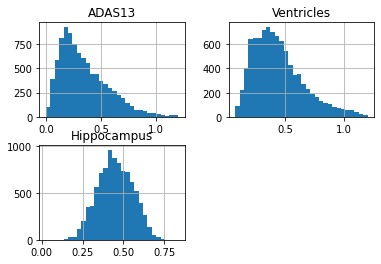

In [453]:
for sub in D1.index.get_level_values(0).unique():
    if len(D1.loc[sub]) < 2:
        D1 = D1.drop(sub, level=0)
        
D1 = D1.sort_index()
D1.hist(bins=30)

In [454]:
D1.describe()

,ADAS13,Ventricles,Hippocampus
count,9461.000000,9405.000000,9285.000000
mean,0.342091,0.443136,0.449653
std,0.219350,0.215317,0.106035
min,0.000000,0.075044,0.025325
25%,0.180000,0.282726,0.374377
50%,0.293400,0.403968,0.447934
75%,0.473333,0.557456,0.526661
max,1.200000,1.196734,0.835764


In [458]:
D1 = D1.fillna(D1.mean())

In [459]:
D1.to_csv('tadpole/data/D1.csv')

In [460]:
X = np.array(D1.index.get_level_values(1))
Y = D1.values
group = np.array(D1.index.get_level_values(0))

In [461]:
data_path = 'tadpole/data/'
np.savetxt(data_path + 'X.csv', X)
np.savetxt(data_path + 'Y.csv', Y, delimiter=',')
np.savetxt(data_path + 'group.csv', group)

In [745]:
D1 = pd.read_csv('tadpole/data/D1.csv').set_index(['ID', 'TIME'])
D1

ADAS13  Ventricles  Hippocampus
ID   TIME                                 
2    74.3  0.3734    0.992890     0.474973
     74.8  0.3934    0.992890     0.474973
     77.3  0.4000    0.992890     0.474973
     79.3  0.4600    0.992890     0.474973
     80.3  0.4200    0.992890     0.474973
...           ...         ...          ...
5294 71.0  0.1800    0.256293     0.286861
5295 75.5  0.3600    0.443136     0.481586
     77.5  0.3600    0.443136     0.481586
5296 69.3  0.2800    0.155411     0.336795
     71.3  0.3000    0.155411     0.336795

[9461 rows x 3 columns]

## Evaluate reconstruction error

In [898]:
path = 'tadpole/'
output_folder = 'output_2_200/'

In [902]:
#rer = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__IndividualRandomEffectsSamples.npy', 
 #             allow_pickle=True)[()]
#trajectories = np.load(path+output_folder+'LongitudinalMetricModel__EstimatedParameters__Trajectory.npy',
 #      allow_pickle=True)[()]
ids = pd.read_csv(path+output_folder+'LongitudinalMetricModel_subject_ids_unique.txt', header=None).values

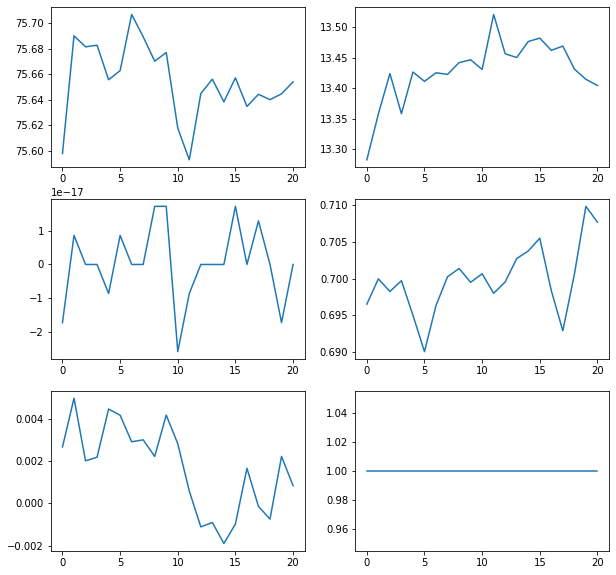

In [900]:
# Plot the non burn-in iterations
fig, axes = plt.subplots(3,2, figsize=(10,10))

axes[0][0].plot(rer['onset_age'].mean(axis=1))
axes[0][1].plot(rer['onset_age'].std(axis=1))
axes[1][0].plot(rer['log_acceleration'].mean(axis=1))
axes[1][1].plot(rer['log_acceleration'].std(axis=1))
axes[2][0].plot(rer['sources'].mean(axis=1))
axes[2][1].plot(rer['sources'].std(axis=1))

plt.show()

In [903]:
tau = [tau[0] for tau in pd.read_csv(path+output_folder+'LongitudinalMetricModel_onset_ages.txt', header=None).values]
xi = [xi[0] for xi in pd.read_csv(path+output_folder+'LongitudinalMetricModel_log_accelerations.txt', header=None).values]
sources = [np.float(sources) for sources in pd.read_csv(path+output_folder+'LongitudinalMetricModel_sources.txt', header=None).values]

ip = pd.DataFrame(columns=['tau','xi','source'], index=[int(idx[0]) for idx in ids])

ip['tau'] = tau
ip['xi'] = xi
ip['source'] = sources

ip

/tmp/ipykernel_2648412/1755275170.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sources = [np.float(sources) for sources in pd.read_csv(path+output_folder+'LongitudinalMetricModel_sources.txt', header=None).values]


,tau,xi,source
2,57.618341,-0.264348,3.112952
3,64.866210,0.085637,0.899488
4,62.222475,-0.091342,-0.398917
5,75.830849,0.235468,-0.317372
6,68.685265,-0.246787,0.005319
...,...,...,...
5290,81.051023,0.365979,-0.414811
5292,87.893524,0.290491,-0.252857
5294,90.138077,-1.012595,-0.812034
5295,71.892702,-0.391262,-0.038335


In [904]:
path = 'tadpole'
data = '/data'

times = [time[0] for time in pd.read_csv(path+data+'/X.csv', header=None).values]
adas = [score[0] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
ven = [score[1] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
hip = [score[2] for score in pd.read_csv(path+data+'/Y.csv', header=None).values]
ids = [int(idx[0]) for idx in pd.read_csv(path+data+'/group.csv', header=None).values]

In [905]:
data = pd.DataFrame(index=[ids, times], columns=[ 'adas', 'ven', 'hip'])
data['hip'] = hip
data['ven'] = ven
data['adas'] = adas
data.index.set_names(['ID','TIME'], inplace=True)
data

adas       ven       hip
ID   TIME                            
2    74.3  0.3734  0.992890  0.474973
     74.8  0.3934  0.992890  0.474973
     77.3  0.4000  0.992890  0.474973
     79.3  0.4600  0.992890  0.474973
     80.3  0.4200  0.992890  0.474973
...           ...       ...       ...
5294 71.0  0.1800  0.256293  0.286861
5295 75.5  0.3600  0.443136  0.481586
     77.5  0.3600  0.443136  0.481586
5296 69.3  0.2800  0.155411  0.336795
     71.3  0.3000  0.155411  0.336795

[9461 rows x 3 columns]

array([[<AxesSubplot:title={'center':'adas'}>,
        <AxesSubplot:title={'center':'ven'}>],
       [<AxesSubplot:title={'center':'hip'}>, <AxesSubplot:>]],
      dtype=object)

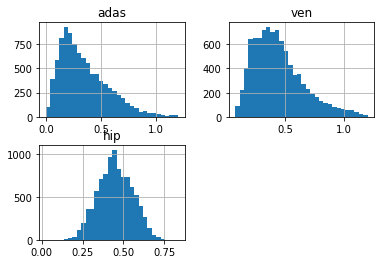

In [879]:
data.hist(bins=30)

In [916]:
reconstructed = pd.read_csv('tadpole/output_2/LongitudinalMetricModel_reconstructed_values.txt', sep=' ', header=None)
reconstructed.columns = ['adas', 'ven', 'hip']
reconstructed.index = data.index

In [917]:
abs(reconstructed-data).describe()

,adas,ven,hip
count,9461.000000,9461.000000,9461.000000
mean,0.048899,0.027263,0.050772
std,0.043796,0.025339,0.040352
min,0.000009,0.000001,0.000016
25%,0.017677,0.009401,0.019540
50%,0.037889,0.020486,0.041823
75%,0.067668,0.037257,0.071538
max,0.451702,0.268242,0.273255


## Evaluating the reconstruction error

In [918]:
path = 'tadpole'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_tadpole.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [919]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

Patient  1330  was estimated with an absurd timeshift tensor(160.2609)
185 good iterations out of 186
175 good iterations out of 176


In [920]:
v0, p0, metric_parameters, modulation_matrix = model._fixed_effects_to_torch_tensors(False)
onset_ages, log_accelerations, sources = model._individual_RER_to_torch_tensors(individual_RER, False)
t0 = model.get_reference_time()

absolute_times = model._compute_absolute_times(dataset.times, log_accelerations, onset_ages)

absolute_times_to_write = []
for elt in absolute_times:
    for e in elt.cpu().data.numpy():
        absolute_times_to_write.append(e)

#np.savetxt(os.path.join(Settings().output_dir, "LongitudinalMetricModel_absolute_times.txt"), np.array(absolute_times_to_write))

model._update_spatiotemporal_reference_frame(absolute_times, p0, v0, metric_parameters,
                                            modulation_matrix)

Patient  1330  was estimated with an absurd timeshift tensor(160.2609)
185 good iterations out of 186
175 good iterations out of 176


In [921]:
predictions = []
subject_ids = []
times = []

targets = dataset.deformable_objects

number_of_subjects = dataset.number_of_subjects
residuals = []

for i in range(number_of_subjects):
    predictions_i = []
    for j, t in enumerate(absolute_times[i]):
        if sources is not None:
            prediction = model.spatiotemporal_reference_frame.get_position(t, sources=sources[i])
        else:
            prediction = model.spatiotemporal_reference_frame.get_position(t)
        predictions_i.append(prediction.cpu().data.numpy())
        predictions.append(prediction.cpu().data.numpy())
        subject_ids.append(dataset.subject_ids[i])
        times.append(dataset.times[i][j])

    targets_i = targets[i].cpu().data.numpy()


In [922]:
predicted = data.copy()
predicted['adas'] = [prediction[0] for prediction in predictions]
predicted['ven'] = [prediction[1] for prediction in predictions]
predicted['hip'] = [prediction[2] for prediction in predictions]

In [923]:
diff = predicted - data
abs(diff).describe()

,adas,ven,hip
count,9461.000000,9.461000e+03,9461.000000
mean,0.052655,3.258836e-02,0.051093
std,0.044351,2.789011e-02,0.040042
min,0.000018,2.093845e-07,0.000029
25%,0.019947,1.237665e-02,0.019849
50%,0.041918,2.601447e-02,0.042434
75%,0.073590,4.487540e-02,0.072061
max,0.494590,2.758881e-01,0.277114


## Leaspy model

In [884]:
data['ID'], data['TIME'] = data.index.get_level_values(0), data.index.get_level_values(1)
data = data.set_index('ID')
individual_parameters = pd.read_csv('leapsy/tadpole.csv').set_index('ID')
individual_parameters.index = data.index.unique()
individual_parameters

FileNotFoundError: [Errno 2] No such file or directory: 'leapsy/tadpole.csv'

## Visualization of tau/alpha correlations with diagnosis

In [912]:
diag = pd.read_csv('~/ADNI-analysis/longitudinal_study/data/ADNI_cog_full.csv',usecols=['ID', 'session_id', 'TIME', 'diagnosis']).set_index('ID')

In [913]:
sub_diag = pd.DataFrame(index=diag.index.unique(), columns=['diag', 'label'])

for sub in sub_diag.index:
    if type(diag.loc[sub]) == pd.core.series.Series:
        sub_diag.drop(sub)
    else:
        if 'AD' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'AD'
            sub_diag.loc[sub]['label'] = 2
        elif 'MCI' in diag.loc[sub].values:
            sub_diag.loc[sub]['diag'] = 'MCI'
            sub_diag.loc[sub]['label'] = 1
        else:
            sub_diag.loc[sub]['diag'] = 'CN'
            sub_diag.loc[sub]['label'] = 0


In [914]:
sub_diag

,diag,label
ID,,
295,CN,0
413,CN,0
559,CN,0
619,AD,2
685,CN,0
...,...,...
6570,CN,0
6574,CN,0
6575,CN,0


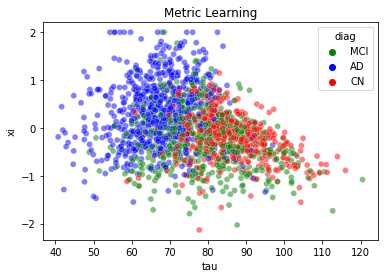

In [915]:
%matplotlib inline

sub_diag = sub_diag.loc[ip.index]
ip['diag'] = sub_diag['diag']
ip['label'] = sub_diag['label']

sns.scatterplot(data = ip,
                x = 'tau', 
                y = 'xi', 
                hue = 'diag',
                alpha=0.5, 
                palette = ['g', 'b', 'r'] )
plt.title('Metric Learning')
plt.show()

## Prediction task

In [937]:
import datetime

path = 'tadpole/'
args = {'verbosity':'INFO', 'output':'personalize',
        'model':path+'/model_tadpole.xml', 'dataset':path+'/data_set.xml', 'parameters':path+'/optimization_parameters_saem.xml'}


"""
Read xml files, set general settings, and call the adapted function.
"""

xml_parameters = dfca.io.XmlParameters()
xml_parameters.read_all_xmls(args['model'],
                             args['dataset'],
                             args['parameters'])

logger = logging.getLogger(__name__)
logging.getLogger('matplotlib').setLevel(logging.ERROR)
logger.setLevel(logging.INFO)

In [938]:
dataset = read_and_create_scalar_dataset(xml_parameters)
model, individual_RER = instantiate_longitudinal_metric_model(xml_parameters, logger, dataset, observation_type='scalar')

185 good iterations out of 186
175 good iterations out of 176


In [939]:
patients_to_predict = D4.index.get_level_values(0)

In [940]:
forecast = pd.read_excel('tadpole/TADPOLE_Template_Submission_Benoit.xlsx').rename(columns={'RID':'ID'}).set_index(['ID', 'Forecast Month'])

In [941]:
pred = pd.DataFrame(columns=['Forecast Month', 'AGE', 'ADAS13', 'Ventricles_ICV'])

for sub in patients_to_predict:
    
    # Compute the number of months between last visit in D1 and beginning of forecast
    last_age = D1.loc[sub].iloc[-1].name
    y, m, d = int(ExamDates.loc[(sub,last_age)].values[0][:4]), int(ExamDates.loc[(sub,last_age)].values[0][5:7]), 1
    last_visit = datetime.datetime(y, m, d)
    y, m, d = int(forecast.loc[sub].iloc[0]['Forecast Date'][:4]), int(forecast.loc[sub].iloc[0]['Forecast Date'][5:7]), 1
    first_forecast = datetime.datetime(y, m, d)
    num_months = (first_forecast.year - last_visit.year) * 12 + (first_forecast.month - last_visit.month)
    
    if sub in ip.index:
        onset_age, log_acceleration, source = ip.loc[sub][['tau', 'xi', 'source']]

        predictions_i = []
        for i in range(60):
            forecast_age = last_age + (i+num_months)/12
            t = np.exp(log_acceleration) * (forecast_age - onset_age) + model.fixed_effects['reference_time']
            prediction = model.spatiotemporal_reference_frame.get_position(torch.tensor(t), sources=[source])
            predictions_i.append(prediction)
        data_sub = pd.DataFrame(columns=['Forecast Month', 'AGE', 'ADAS13', 'Ventricles_ICV'])
        data_sub['Forecast Month'] = [i for i in range(1,61)]
        data_sub['AGE'] = [last_age + (i+num_months)/12 for i in range(60)]
        data_sub['ADAS13'] = [float(prediction[0]) for prediction in predictions_i]
        data_sub['Ventricles_ICV'] = [float(prediction[1]) for prediction in predictions_i]
        data_sub.index = [sub for i in range(60)]

        #data_sub.columns = ['ADAS13', 'Ventricles_ICV', 'Hippocampus_ICV']
        pred = pred.append(data_sub)
    else:
        print(sub)
pred['ID'] = pred.index
pred = pred.set_index(['ID', 'Forecast Month'])
pred

/tmp/ipykernel_2648412/1980181560.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  y, m, d = int(ExamDates.loc[(sub,last_age)].values[0][:4]), int(ExamDates.loc[(sub,last_age)].values[0][5:7]), 1


AGE    ADAS13  Ventricles_ICV
ID   Forecast Month                                     
31   1               89.700000  0.155946        0.417482
     2               89.783333  0.156297        0.418141
     3               89.866667  0.156645        0.418818
     4               89.950000  0.156994        0.419495
     5               90.033333  0.157342        0.420171
...                        ...       ...             ...
5296 56              77.966667  0.462282        0.307535
     57              78.050000  0.466827        0.309810
     58              78.133333  0.469922        0.311557
     59              78.216667  0.474838        0.314093
     60              78.300000  0.477782        0.315814

[8460 rows x 3 columns]

In [942]:
if 'ADAS13' in forecast.columns:
    forecast = forecast.drop(['ADAS13', 'Ventricles_ICV'], axis=1)
estimated_D4 = forecast.join(pred, on=['ID', 'Forecast Month']).drop(['AGE'], axis=1)

In [943]:
estimated_D4['ADAS13'] = 50 * estimated_D4['ADAS13']
estimated_D4['Ventricles_ICV'] = 0.06 * estimated_D4['Ventricles_ICV']

In [944]:
estimated_D4.index = estimated_D4.index.set_names(['RID', 'Forecast Month'])
estimated_D4.to_csv('tadpole/TADPOLE_Submission_Benoit.csv')

### Compare locally D4 and estimated_D4

In [945]:
columns = ['RID', 'AGE', 'Ventricles', 'ADAS13', 'ICV', 'ScanDate']
D4 = pd.read_csv(path+'TADPOLE_D4_corr.csv').set_index('RID')

In [946]:
formatted_dates = [data[:7] for data in D4['ScanDate'].values]
D4['ScanDate'] = formatted_dates
D4 = D4.rename(columns={'ScanDate' : 'Forecast Date', 'Ventricles' : 'Ventricles_ICV'})
D4['RID'] = D4.index
D4 = D4.set_index(['RID', 'Forecast Date'])
D4 = D4[['ADAS13', 'Ventricles_ICV']].dropna()

In [947]:
D4

ADAS13  Ventricles_ICV
RID  Forecast Date                        
31   2018-04         14.00        0.029783
56   2019-01         14.00        0.018841
69   2018-01         19.00        0.030050
     2019-01         22.00        0.030151
74   2019-01         17.67        0.053344
...                    ...             ...
5285 2018-10         22.00        0.062427
5289 2018-05         15.67        0.026308
5290 2018-10          6.00        0.011296
5292 2018-09         15.33        0.017878
5296 2018-11         15.00        0.015177

[141 rows x 2 columns]

In [948]:
estimated_D4_local = estimated_D4.copy()
estimated_D4_local['RID'] = estimated_D4_local.index.get_level_values(0)
estimated_D4_local = estimated_D4_local.set_index(['RID', 'Forecast Date'])

In [949]:
commun_subs = [visit for visit in D4.index if visit in estimated_D4_local.index]
abs(D4 - estimated_D4_local)[['ADAS13', 'Ventricles_ICV']].describe(percentiles=[.25,.5,.75,.85,.95])

,ADAS13,Ventricles_ICV
count,155.000000,155.000000
mean,4.905154,0.005976
std,4.728517,0.005925
min,0.007409,0.000049
25%,1.901717,0.002341
50%,3.404519,0.004611
75%,6.315168,0.007664
85%,8.242171,0.009682
95%,13.686324,0.015788
max,27.394062,0.033671


In [814]:
estimated_D4[['ADAS13','Ventricles_ICV']].describe(percentiles=[.25,.5,.8,.9,.95,.98])

,ADAS13,Ventricles_ICV
count,8460.000000,8460.000000
mean,14.136192,0.026991
std,6.488590,0.011217
min,0.273242,0.007410
25%,9.797967,0.018050
50%,13.040520,0.026678
80%,18.817369,0.034645
90%,22.753288,0.040978
95%,25.858692,0.051788
98%,28.702391,0.057372
